# ![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)
---
# Experiment 2 — BART & T5 (Pretrained Seq2Seq Models)
---

This notebook evaluates **purpose-built summarization models**:

- **BART** — denoising autoencoder for seq2seq  
- **T5** — text-to-text transformer trained on C4  

Both are pretrained encoder–decoder models and provide strong baselines compared to Experiment 1's custom BERT→GPT-2 Frankenstein.

We reuse shared components from `src/`:

- SAMSum dataset loader  
- `SummaryDataset`  
- BART / T5 model builders  
- Shared seq2seq trainer (early stopping + checkpoints)  
- Qualitative preview utilities  

## 1. Environment Setup

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
from pathlib import Path
import pandas as pd
import sys
import json

from torch.utils.data import DataLoader
import torch.optim as optim

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2. Imports from src/

In [2]:
from src.data.load_data import load_samsum
from src.data.preprocess import SummaryDataset
from src.models.build_bart import build_bart_model
from src.models.build_t5 import build_t5_model
from src.train.trainer_seq2seq import train_model
from src.eval.qualitative import qualitative_samples
from src.utils.logging import heading, line

/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Configuration

In [3]:
# =============================================================================
# TRAINING FLAGS - Set these to control what runs
# =============================================================================
RUN_TRAINING_BART = True   # Set False to load BART from checkpoint
RUN_TRAINING_T5 = True     # Set False to load T5 from checkpoint

# =============================================================================
# HYPERPARAMETERS
# =============================================================================
MAX_SOURCE_LEN = 512
MAX_TARGET_LEN = 128

BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 3e-5     # good default for pretrained seq2seq
PATIENCE = 2             # early stopping
GRAD_ACCUM_STEPS = 1

# =============================================================================
# PATHS
# =============================================================================
BART_CKPT_DIR = PROJECT_ROOT / "models" / "bart" / "best"
BART_HIST_PATH = PROJECT_ROOT / "models" / "bart" / "history.csv"
SAVE_DIR_BART = PROJECT_ROOT / "models" / "bart" / "final"

T5_CKPT_DIR = PROJECT_ROOT / "models" / "t5" / "best"
T5_HIST_PATH = PROJECT_ROOT / "models" / "t5" / "history.csv"
SAVE_DIR_T5 = PROJECT_ROOT / "models" / "t5" / "final"

T5_PREFIX_DEFAULT = "summarize: "

## 4. Load SAMSum

In [4]:
train_df, val_df, test_df = load_samsum()
len(train_df), len(val_df), len(test_df)

(14731, 818, 819)

---
# BART
---

## 5. Build or Load BART Model

In [5]:
from transformers import BartForConditionalGeneration, BartTokenizer, GenerationConfig

if RUN_TRAINING_BART:
    # Build fresh model for training
    bart_model, bart_tokenizer = build_bart_model()
    bart_model = bart_model.to(device)
    
    # Configure generation to respect our target length
    gen_cfg = bart_model.generation_config
    gen_cfg.max_length = MAX_TARGET_LEN
    gen_cfg.min_length = 5
    gen_cfg.no_repeat_ngram_size = 3
    gen_cfg.length_penalty = 2.0
    gen_cfg.num_beams = 4
    
    print("Built fresh BART model for training.")
    
else:
    # Load from checkpoint
    print("Loading BART from checkpoint...")
    
    # Try to load from best checkpoint first, fall back to final
    if BART_CKPT_DIR.exists():
        load_dir = BART_CKPT_DIR
    elif SAVE_DIR_BART.exists():
        load_dir = SAVE_DIR_BART
    else:
        raise FileNotFoundError(
            f"No saved BART model found.\n"
            f"Checked: {BART_CKPT_DIR}\n"
            f"Checked: {SAVE_DIR_BART}\n"
            f"Set RUN_TRAINING_BART=True to train a new model."
        )
    
    bart_model = BartForConditionalGeneration.from_pretrained(load_dir).to(device)
    bart_tokenizer = BartTokenizer.from_pretrained(load_dir)
    
    # ADD THIS BLOCK:
    # Load training metadata if available
    metadata_path = load_dir / "training_metadata.json"
    if metadata_path.exists():
        with open(metadata_path, 'r') as f:
            bart_metadata = json.load(f)
        print(f"  Training metadata:")
        print(f"    Best epoch: {bart_metadata.get('best_epoch')}")
        print(f"    Weights from epoch: {bart_metadata.get('weights_epoch')}")
        if bart_metadata.get('early_stopped'):
            print(f"    (Training stopped early)")
    else:
        print("  No training metadata found.")
    
    # Load generation config if available
    try:
        bart_model.generation_config = GenerationConfig.from_pretrained(load_dir)
        print(f"Loaded BART model and generation config from: {load_dir}")
    except Exception:
        print(f"Loaded BART model from: {load_dir}")
        print("No saved generation config found. Setting defaults.")
        gen_cfg = bart_model.generation_config
        gen_cfg.max_length = MAX_TARGET_LEN
        gen_cfg.min_length = 5
        gen_cfg.no_repeat_ngram_size = 3
        gen_cfg.length_penalty = 2.0
        gen_cfg.num_beams = 4

bart_tokenizer

/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/torch/nn/modules/module.py:1329: UserWarning: expandable_segments not supported on this platform (Triggered internally at /pytorch/c10/hip/HIPAllocatorConfig.h:29.)
  return t.to(


Built fresh BART model for training.


BartTokenizer(name_or_path='facebook/bart-base', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}
)

## 6. Prepare BART Datasets

In [6]:
heading("BART: Prepare datasets")

bart_train_dataset = SummaryDataset(
    train_df,
    encoder_tokenizer=bart_tokenizer,
    decoder_tokenizer=bart_tokenizer,
    max_source_len=MAX_SOURCE_LEN,
    max_target_len=MAX_TARGET_LEN,
    source_prefix="",  # No prefix for BART
)

bart_val_dataset = SummaryDataset(
    val_df,
    encoder_tokenizer=bart_tokenizer,
    decoder_tokenizer=bart_tokenizer,
    max_source_len=MAX_SOURCE_LEN,
    max_target_len=MAX_TARGET_LEN,
    source_prefix="",  # No prefix for BART
)

bart_train_loader = DataLoader(
    bart_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

bart_val_loader = DataLoader(
    bart_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

print(f"Train batches: {len(bart_train_loader)}, Val batches: {len(bart_val_loader)}")


BART: Prepare datasets
Train batches: 3683, Val batches: 205


## 7. Train BART (or Load History)

In [7]:
if RUN_TRAINING_BART:
    heading("BART: Training")
    
    bart_optimizer = optim.AdamW(bart_model.parameters(), lr=LEARNING_RATE)
    
    bart_history = train_model(
        model=bart_model,
        train_loader=bart_train_loader,
        val_loader=bart_val_loader,
        optimizer=bart_optimizer,
        tokenizer=bart_tokenizer,
        device=device,
        epochs=EPOCHS,
        max_target_len=MAX_TARGET_LEN,
        checkpoint_dir=str(BART_CKPT_DIR),
        patience=PATIENCE,
        grad_accum_steps=GRAD_ACCUM_STEPS,
        use_amp=True, 
    )
    
    # Save training history
    BART_HIST_PATH.parent.mkdir(parents=True, exist_ok=True)
    bart_history.to_csv(BART_HIST_PATH, index=False)
    print(f"Saved BART training history to: {BART_HIST_PATH}")
    
else:
    heading("BART: Loading training history")
    
    if BART_HIST_PATH.exists():
        bart_history = pd.read_csv(BART_HIST_PATH)
        print(f"Loaded BART training history from: {BART_HIST_PATH}")
    else:
        bart_history = None
        print("No training history found for BART.")

/home/timnevits/projects/flatiron-language-models-for-ai/src/train/trainer_seq2seq.py:151: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None



BART: Training


Epoch 1/5:   0%|          | 0/3683 [00:00<?, ?it/s]/home/timnevits/projects/flatiron-language-models-for-ai/src/train/trainer_seq2seq.py:178: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/integrations/sdpa_attention.py:96: UserWarning: Using AOTriton backend for Efficient Attention forward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/attention.hip:1180.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Using AOTriton backend for Efficient Attention backward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/attention_backward.hip:463.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward


Epoch 1 complete.
  Train loss: 1.8856
  Val loss:   1.5901
  ✓ New best validation loss!
    Saving checkpoint to /home/timnevits/projects/flatiron-language-models-for-ai/models/bart/best


/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
Validating: 100%|██████████| 205/205 [01:51<00:00,  1.84it/s]



Epoch 2 complete.
  Train loss: 1.5460
  Val loss:   1.5652
  ✓ New best validation loss!
    Saving checkpoint to /home/timnevits/projects/flatiron-language-models-for-ai/models/bart/best


Validating: 100%|██████████| 205/205 [01:53<00:00,  1.80it/s]



Epoch 3 complete.
  Train loss: 1.3388
  Val loss:   1.5666
  No improvement for 1 epoch(s).


Validating: 100%|██████████| 205/205 [01:45<00:00,  1.95it/s]



Epoch 4 complete.
  Train loss: 1.1737
  Val loss:   1.5920
  No improvement for 2 epoch(s).

🛑 Early stopping triggered!

📦 Reloading best model from epoch 2...
  ✓ Best model weights restored successfully.
    Verified: Model is now from epoch 2
  Saved training metadata to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bart/best/training_metadata.json
Saved BART training history to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bart/history.csv


In [8]:
if bart_history is not None:
    display(bart_history)

,epoch,train_loss,val_loss,rouge1,rouge2,rougeL,rougeLsum,improved
0,1,1.885584,1.590053,0.503444,0.255808,0.418490,0.418569,True
1,2,1.545978,1.565206,0.507573,0.267113,0.425039,0.424737,True
2,3,1.338845,1.566630,0.514308,0.271162,0.432454,0.432198,False
3,4,1.173720,1.592034,0.508709,0.270918,0.427940,0.428200,False


## 8. BART Loss Curves

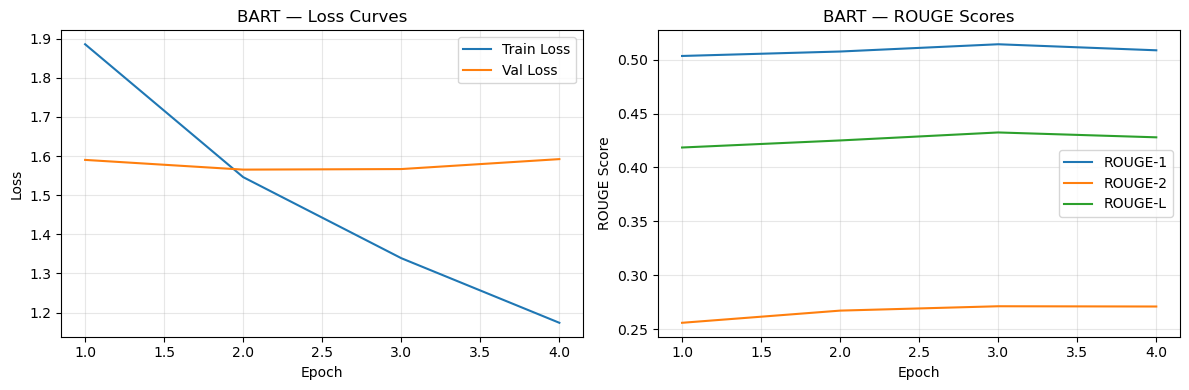

In [9]:
if bart_history is not None:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss curves
    axes[0].plot(bart_history["epoch"], bart_history["train_loss"], label="Train Loss")
    axes[0].plot(bart_history["epoch"], bart_history["val_loss"], label="Val Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("BART — Loss Curves")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # ROUGE curves
    axes[1].plot(bart_history["epoch"], bart_history["rouge1"], label="ROUGE-1")
    axes[1].plot(bart_history["epoch"], bart_history["rouge2"], label="ROUGE-2")
    axes[1].plot(bart_history["epoch"], bart_history["rougeL"], label="ROUGE-L")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("ROUGE Score")
    axes[1].set_title("BART — ROUGE Scores")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Qualitative BART Examples

In [10]:
heading("BART: Qualitative samples")

qualitative_samples(
    df=val_df,
    model=bart_model,
    encoder_tokenizer=bart_tokenizer,
    decoder_tokenizer=bart_tokenizer,
    device=device,
    max_source_len=MAX_SOURCE_LEN,
    max_target_len=MAX_TARGET_LEN,
    source_prefix="",  # No prefix for BART
    n=5,
    seed=42,
)


BART: Qualitative samples
--- 5 qualitative samples (seed=42) ---
ID 86
DIALOGUE: Edd: wow, did you hear that they're transferring us to a different department? | Rose: whaaaaat :o | Rose: no! where'd you hear that? | Edd: well, it's quite official | Edd: Anderson just told us | Rose: and do you know what it changes for us? | Edd: they won't change the professors | Edd: but i know the paperwor ...
HUMAN: Rose and Edd will be transferred to a new department. Their professors will not change but paperwork will become more difficult.
MODEL: Edd and Rose are learning about the transfer of Anderson and Rose to a different department. They will not change the professors.
--------------------------------------------------------------------------------
ID 431
DIALOGUE: Tom: Where is the "Sala del Capitolo" | Kevin: it's in the main building | Martin: The one with the huge round table | Tom: ok! I know. | Tom: Thx ...
HUMAN: "Sala del Capitolo" Tom is looking for is in the main building.
MODEL

## 10. Save Full BART Model

In [11]:
if RUN_TRAINING_BART:
    heading("BART: Saving final model")
    
    SAVE_DIR_BART.mkdir(parents=True, exist_ok=True)
    
    bart_model.save_pretrained(SAVE_DIR_BART)
    bart_tokenizer.save_pretrained(SAVE_DIR_BART)
    
    # Also save generation config
    if hasattr(bart_model, 'generation_config'):
        bart_model.generation_config.save_pretrained(SAVE_DIR_BART)
    
    print(f"Saved BART model to: {SAVE_DIR_BART}")
else:
    print("Skipping BART save (model was loaded from checkpoint).")


BART: Saving final model
Saved BART model to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bart/final


---
# T5
---

T5 is a text-to-text model. For summarization it expects a task prefix like:

`"summarize: {dialogue_text}"`

We apply this prefix to the **source** text only; targets stay as the human summaries.

## 11. Build or Load T5 Model

In [12]:
heading("T5: Build model and tokenizer")

from transformers import T5ForConditionalGeneration, T5Tokenizer, GenerationConfig

if RUN_TRAINING_T5:
    # Build fresh model for training
    t5_model, t5_tokenizer = build_t5_model("t5-small")
    t5_model = t5_model.to(device)
    
    # Configure generation
    gen_cfg_t5 = t5_model.generation_config
    gen_cfg_t5.max_length = MAX_TARGET_LEN
    gen_cfg_t5.min_length = 5
    gen_cfg_t5.no_repeat_ngram_size = 3
    gen_cfg_t5.length_penalty = 2.0
    gen_cfg_t5.num_beams = 4
    
    # Use the default prefix for new training
    t5_prefix_used = T5_PREFIX_DEFAULT
    print(f"Built fresh T5 model for training with prefix: '{t5_prefix_used}'")
    
else:
    # Load from checkpoint
    print("Loading T5 from checkpoint...")
    
    # Try to load from best checkpoint first, fall back to final
    if T5_CKPT_DIR.exists():
        load_dir = T5_CKPT_DIR
    elif SAVE_DIR_T5.exists():
        load_dir = SAVE_DIR_T5
    else:
        raise FileNotFoundError(
            f"No saved T5 model found.\n"
            f"Checked: {T5_CKPT_DIR}\n"
            f"Checked: {SAVE_DIR_T5}\n"
            f"Set RUN_TRAINING_T5=True to train a new model."
        )
    
    t5_model = T5ForConditionalGeneration.from_pretrained(load_dir).to(device)
    t5_tokenizer = T5Tokenizer.from_pretrained(load_dir)
    
    # CRITICAL: Load the prefix that was used during training
    prefix_path = load_dir / "source_prefix.txt"
    if prefix_path.exists():
        t5_prefix_used = prefix_path.read_text().strip()
        print(f"  ✓ Loaded source prefix from checkpoint: '{t5_prefix_used}'")
        
        # Warn if it differs from the default (just for user awareness)
        if t5_prefix_used != T5_PREFIX_DEFAULT:
            print(f"    (Note: differs from default '{T5_PREFIX_DEFAULT}')")
    else:
        # This is a PROBLEM - we don't know what prefix was used!
        print(f"  ⚠️  WARNING: No source_prefix.txt found in checkpoint!")
        print(f"      The model may have been trained with a different prefix.")
        print(f"      Assuming default prefix: '{T5_PREFIX_DEFAULT}'")
        print(f"      If results are poor, check what prefix was used during training.")
        t5_prefix_used = T5_PREFIX_DEFAULT
    
    # Load generation config if available
    try:
        t5_model.generation_config = GenerationConfig.from_pretrained(load_dir)
        print(f"  ✓ Loaded generation config from checkpoint")
    except Exception:
        print(f"  ⚠️  No saved generation config found. Setting defaults.")
        gen_cfg_t5 = t5_model.generation_config
        gen_cfg_t5.max_length = MAX_TARGET_LEN
        gen_cfg_t5.min_length = 5
        gen_cfg_t5.no_repeat_ngram_size = 3
        gen_cfg_t5.length_penalty = 2.0
        gen_cfg_t5.num_beams = 4

    metadata_path = load_dir / "training_metadata.json"
    if metadata_path.exists():
        with open(metadata_path, 'r') as f:
            t5_metadata = json.load(f)
        print(f"  ✓ Training metadata:")
        print(f"      Best epoch: {t5_metadata.get('best_epoch')}")
        print(f"      Weights from epoch: {t5_metadata.get('weights_epoch')}")
        if t5_metadata.get('early_stopped'):
            print(f"      (Training stopped early)")
    else:
        print(f"  ⚠️  No training metadata found (older checkpoint format)")

t5_tokenizer


T5: Build model and tokenizer


ImportError: 
T5Tokenizer requires the SentencePiece library but it was not found in your environment. Check out the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


## 12. Prepare T5 Datasets

In [ ]:
heading("T5: Prepare datasets (with 'summarize:' prefix)")

t5_train_dataset = SummaryDataset(
    train_df,
    encoder_tokenizer=t5_tokenizer,
    decoder_tokenizer=t5_tokenizer,
    max_source_len=MAX_SOURCE_LEN,
    max_target_len=MAX_TARGET_LEN,
    source_prefix=t5_prefix_used,
)

t5_val_dataset = SummaryDataset(
    val_df,
    encoder_tokenizer=t5_tokenizer,
    decoder_tokenizer=t5_tokenizer,
    max_source_len=MAX_SOURCE_LEN,
    max_target_len=MAX_TARGET_LEN,
    source_prefix=t5_prefix_used,
)

t5_train_loader = DataLoader(
    t5_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

t5_val_loader = DataLoader(
    t5_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

print(f"Train batches: {len(t5_train_loader)}, Val batches: {len(t5_val_loader)}")

## 13. Train T5 (or Load History)

In [ ]:
if RUN_TRAINING_T5:
    heading("T5: Training")
    
    # Ensure checkpoint directory exists
    T5_CKPT_DIR.mkdir(parents=True, exist_ok=True)
    
    # =========================================================================
    # IMPORTANT: Save prefix BEFORE training starts
    # This ensures it's always present if a checkpoint exists, even if
    # training is interrupted or crashes partway through.
    # =========================================================================
    prefix_path_ckpt = T5_CKPT_DIR / "source_prefix.txt"
    prefix_path_ckpt.write_text(t5_prefix_used)
    print(f"Saved source prefix to: {prefix_path_ckpt}")
    print(f"Using source prefix: '{t5_prefix_used}'")
    
    t5_optimizer = optim.AdamW(t5_model.parameters(), lr=LEARNING_RATE)
    
    t5_history = train_model(
        model=t5_model,
        train_loader=t5_train_loader,
        val_loader=t5_val_loader,
        optimizer=t5_optimizer,
        tokenizer=t5_tokenizer,
        device=device,
        epochs=EPOCHS,
        max_target_len=MAX_TARGET_LEN,
        checkpoint_dir=str(T5_CKPT_DIR),
        patience=PATIENCE,
        grad_accum_steps=GRAD_ACCUM_STEPS,
        use_amp=True, 
    )
    
    # Save training history
    T5_HIST_PATH.parent.mkdir(parents=True, exist_ok=True)
    t5_history.to_csv(T5_HIST_PATH, index=False)
    print(f"Saved T5 training history to: {T5_HIST_PATH}")
    
else:
    heading("T5: Loading training history")
    
    if T5_HIST_PATH.exists():
        t5_history = pd.read_csv(T5_HIST_PATH)
        print(f"Loaded T5 training history from: {T5_HIST_PATH}")
    else:
        t5_history = None
        print("No training history found for T5.")


In [ ]:
if t5_history is not None:
    display(t5_history)

## 14. T5 Loss Curves

In [ ]:
if t5_history is not None:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss curves
    axes[0].plot(t5_history["epoch"], t5_history["train_loss"], label="Train Loss")
    axes[0].plot(t5_history["epoch"], t5_history["val_loss"], label="Val Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("T5 — Loss Curves")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # ROUGE curves
    axes[1].plot(t5_history["epoch"], t5_history["rouge1"], label="ROUGE-1")
    axes[1].plot(t5_history["epoch"], t5_history["rouge2"], label="ROUGE-2")
    axes[1].plot(t5_history["epoch"], t5_history["rougeL"], label="ROUGE-L")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("ROUGE Score")
    axes[1].set_title("T5 — ROUGE Scores")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 15. Qualitative T5 Examples

In [ ]:
heading("T5: Qualitative samples")

qualitative_samples(
    df=val_df,
    model=t5_model,
    encoder_tokenizer=t5_tokenizer,
    decoder_tokenizer=t5_tokenizer,
    device=device,
    max_source_len=MAX_SOURCE_LEN,
    max_target_len=MAX_TARGET_LEN,
    source_prefix=t5_prefix_used,
    n=5,
    seed=42,
)

## 16. Save Full T5 Model

In [ ]:
if RUN_TRAINING_T5:
    heading("T5: Saving final model")
    
    SAVE_DIR_T5.mkdir(parents=True, exist_ok=True)
    
    # Save model and tokenizer
    t5_model.save_pretrained(SAVE_DIR_T5)
    t5_tokenizer.save_pretrained(SAVE_DIR_T5)
    
    # Save generation config
    if hasattr(t5_model, 'generation_config'):
        t5_model.generation_config.save_pretrained(SAVE_DIR_T5)
    
    # CRITICAL: Save the prefix used during training
    # Without this, future users won't know how to use the model!
    prefix_path = SAVE_DIR_T5 / "source_prefix.txt"
    prefix_path.write_text(t5_prefix_used)
    
    # Verify the save worked
    saved_prefix = prefix_path.read_text().strip()
    if saved_prefix != t5_prefix_used:
        raise RuntimeError(f"Prefix save verification failed! Expected '{t5_prefix_used}', got '{saved_prefix}'")
    
    print(f"✓ Saved T5 model to: {SAVE_DIR_T5}")
    print(f"✓ Saved source prefix: '{t5_prefix_used}'")


In [ ]:
if RUN_TRAINING_T5:
    heading("T5: Creating usage documentation")
    
    # Use an f-string so the actual prefix is included in the documentation
    readme_content = f"""# T5 Dialogue Summarization Model

## Usage

This model was fine-tuned for dialogue summarization. 

**IMPORTANT:** You must prepend `"{t5_prefix_used}"` to your input text!

### Example

```python
from transformers import T5ForConditionalGeneration, T5Tokenizer

model = T5ForConditionalGeneration.from_pretrained("path/to/this/model")
tokenizer = T5Tokenizer.from_pretrained("path/to/this/model")

dialogue = \"\"\"
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Amanda: Sorry, I don't
Hannah: Ok, thanks
\"\"\"

# IMPORTANT: Add the prefix!
input_text = "{t5_prefix_used}" + dialogue

inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
outputs = model.generate(**inputs, max_length=128)
summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(summary)
```

## Training Details

- Base model: t5-small
- Dataset: SAMSum
- Source prefix: `"{t5_prefix_used}"`
- Max source length: {MAX_SOURCE_LEN}
- Max target length: {MAX_TARGET_LEN}

## Files in this directory

- `pytorch_model.bin` or `model.safetensors`: Model weights
- `config.json`: Model configuration
- `tokenizer_config.json`, `spiece.model`, etc.: Tokenizer files
- `generation_config.json`: Generation settings
- `source_prefix.txt`: The prefix used during training (for programmatic access)
- `README.md`: This file
"""
    
    readme_path = SAVE_DIR_T5 / "README.md"
    readme_path.write_text(readme_content)
    print(f"Created usage documentation at: {readme_path}")


---
# 17. Side-by-Side Comparison
---

In [ ]:
heading("Side-by-Side: BART vs T5")

# Compare on the same samples
comparison_samples = val_df.sample(3, random_state=42)

for idx, row in comparison_samples.iterrows():
    dialog = row["dialogue"]
    ref = row["summary"]
    
    # Generate BART summary
    from src.eval.qualitative import generate_summary
    
    bart_pred = generate_summary(
        model=bart_model,
        encoder_tokenizer=bart_tokenizer,
        decoder_tokenizer=bart_tokenizer,
        text=dialog,
        device=device,
        max_source_len=MAX_SOURCE_LEN,
        max_target_len=MAX_TARGET_LEN,
        source_prefix="",
    )
    
    t5_pred = generate_summary(
        model=t5_model,
        encoder_tokenizer=t5_tokenizer,
        decoder_tokenizer=t5_tokenizer,
        text=dialog,
        device=device,
        max_source_len=MAX_SOURCE_LEN,
        max_target_len=MAX_TARGET_LEN,
        source_prefix=t5_prefix_used,
    )
    
    print(f"=== Example {idx} ===")
    print(f"DIALOGUE: {dialog[:300].replace(chr(10), ' | ')}...")
    print(f"HUMAN:    {ref}")
    print(f"BART:     {bart_pred}")
    print(f"T5:       {t5_pred}")
    print("-" * 80)

---
# 18. Summary Comparison Table
---

In [ ]:
heading("Final ROUGE Comparison")

summary_data = []

def get_best_epoch_row(history_df):
    """
    Get the row corresponding to the best epoch.
    Uses the 'improved' column if available, otherwise falls back to finding min val_loss.
    """
    # The best epoch is the LAST one that improved (since each improvement becomes the new best)
    if "improved" in history_df.columns:
        improved_rows = history_df[history_df["improved"] == True]
        if len(improved_rows) > 0:
            return improved_rows.iloc[-1]  # Last improvement = final best
    
    # Fallback: find the row with minimum validation loss
    return history_df.loc[history_df["val_loss"].idxmin()]


if bart_history is not None:
    best_bart = get_best_epoch_row(bart_history)
    summary_data.append({
        "Model": "BART",
        "Best Epoch": int(best_bart["epoch"]),
        "Val Loss": f"{best_bart['val_loss']:.4f}",
        "ROUGE-1": f"{best_bart['rouge1']:.4f}",
        "ROUGE-2": f"{best_bart['rouge2']:.4f}",
        "ROUGE-L": f"{best_bart['rougeL']:.4f}",
    })

if t5_history is not None:
    best_t5 = get_best_epoch_row(t5_history)
    summary_data.append({
        "Model": "T5",
        "Best Epoch": int(best_t5["epoch"]),
        "Val Loss": f"{best_t5['val_loss']:.4f}",
        "ROUGE-1": f"{best_t5['rouge1']:.4f}",
        "ROUGE-2": f"{best_t5['rouge2']:.4f}",
        "ROUGE-L": f"{best_t5['rougeL']:.4f}",
    })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
else:
    print("No training history available to compare.")

---
# 19. Key Takeaways — Experiment 2

*Fill this in after training completes:*

- Which model achieved better ROUGE scores?
- How many epochs did each model need before early stopping?
- Qualitative differences in summary style?
- Training time comparison?
- Any notable failure cases?

---